In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
import shutil


import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from Dataprocessing import get_daily_tp_rate, prep_hindcast, crop_netCDF

# from verification import get_inits, load_hindcast_data, load_verification_data
from climpred.preprocessing.shared import set_integer_time_axis
from climpred import HindcastEnsemble
# from climpred.utils import convert_init_lead_to_valid_time_lead

C:\Users\sb123\.conda\envs\Thesis2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading and pre-processing observations
Read in "quasi-observations" from ERA5, which have been (conservatively) regridded from 0.25°x0.25° latlon to 1°x1° latlon (using MPI CDO), cropped to the spatial domain of interest (5 - 15W and 47 to 55N) and also aggregated (sum) from hourly to daily values by using function Dataprocessing.ERA5_hourly_daily().

Data amount of ERA5 seems to be OK to handle: 831699 datapoints. Shape: (8401, 9, 11)

The ERA5 data still contains some very small negative values, which are replaced with zeros in the next step:
-8.940698171500117e-05 

0.024 percent of the gridpoints have negative values
Now the data looks good
Max. daily precipitation: 94.08016967773438
Min. daily precipitation: 0.0 

CPU times: total: 297 ms
Wall time: 1.1 s


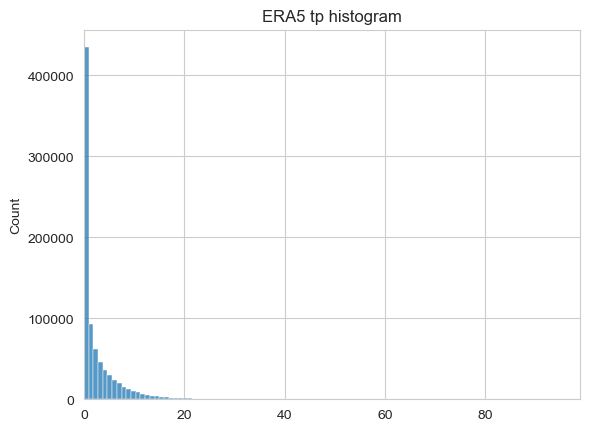

In [6]:
%%time
obs = xr.open_mfdataset(r"E:\Massendaten\ERA5\Cropped\Daily\Regrid\*.nc", chunks="auto")["tp"]


print(f"Data amount of ERA5 seems to be OK to handle: {obs.size} datapoints. Shape: {obs.shape}\n")
attrs = obs.attrs
obs = obs * 1000 #Careful: Attrs are dropped when doing basic arithmetics: https://github.com/pydata/xarray/issues/1271
obs.attrs = attrs
obs.attrs["units"] = "mm" #update the unit

# https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ
print("The ERA5 data still contains some very small negative values, which are replaced with zeros in the next step:")
print(f"{obs.values.min()} \n")
print(f"{round(np.count_nonzero(obs.values < 0) / obs.size,3)} percent of the gridpoints have negative values")

# I did not find a straightforward way of replacing all negative pr values with zeros in Xarray. Workaround:
obs = obs.where(obs > 0) # negative values to NAN
obs = obs.fillna(0) # NaNs to 0
print("Now the data looks good")
print(f"Max. daily precipitation: {obs.max().values}")
print(f"Min. daily precipitation: {obs.min().values} \n")

fig, ax = plt.subplots()
sns.histplot(obs.values.flat, ax=ax, bins=100)
ax.set_xlim(left=0)
ax.set(title="ERA5 tp histogram")

# Store obs in .nc file
obs.to_netcdf(r"E:\Massendaten\ERA5\Cropped\Daily\Regrid\Final\Observations_fin.nc")

## Reading and pre-processing SEAS5 model data
### Crop
At first a box of lat 47 - 55N and lon 5 - 15E will be cropped.

In [ ]:
%%time
crop_netCDF(r"D:\Massendaten\ECMWF\SEAS5_Global", 47, 55, 5, 15, globpat="*_total_precipitation.nc", to_netcdf=True)

### Disaggregation
Then the accumulated total precipitation data will need to be disaggregated over dim = "time". See [ECMWF Conversion table for accumulated variables (total precipitation/fluxes)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790)

In [ ]:
%%time
get_daily_tp_rate(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped", r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated", globpat="*total_precipitation_box.nc")

Before analysing the data I run some plausibility checks / compute basic statistics to see if there are any problems with the data. This includes:
 ### Plotting a histogram over all daily tp values for each file.

In [7]:
path = Path(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated")
for file in tqdm(list((path).glob("*disaggregated.nc"))):
    da = xr.open_dataset(file, chunks="auto")["tp"]
    da *= 1_000
    fig, ax = plt.subplots()
    sns.histplot(da.stack(all = ["time", "number", "latitude", "longitude"]).values, bins = 50, ax=ax)
    fig.savefig(path / (file.parts[-1][:-3] + ".png"), dpi=300)
    plt.close()

100%|██████████| 276/276 [03:48<00:00,  1.21it/s]


The issue with the interspersed histograms with giant outlier values and the rest of the distribution centered on zero persists. This is why for now I filter out all datasets with max() values larger than 300 mm. 20 Files will be discarded (for now). This is identical to the number of figures, where the histogram looks odd.
<br>

## Pre-processing
Now the data needs to be modified so that it complies to the climpred requirements: https://climpred.readthedocs.io/en/stable/setting-up-data.html

This includes mostly manipulations to the coords and dims, e.g. converting the time axis to int days lead or adding an init dimension along which the datasets are concatenated, which specifies the initialisation date of each forecast (i.e. the 1st day of each month for SEAS5).

146866500 data points... quite a bit of data! Shape: (276, 25, 9, 11, 215)
Just like the observations the forecasts also contain negative pr values:
Min. -1.5904903411865234 

Now the data looks good
Max. daily precipitation: 135.79415893554688
Min. daily precipitation: 0.0 



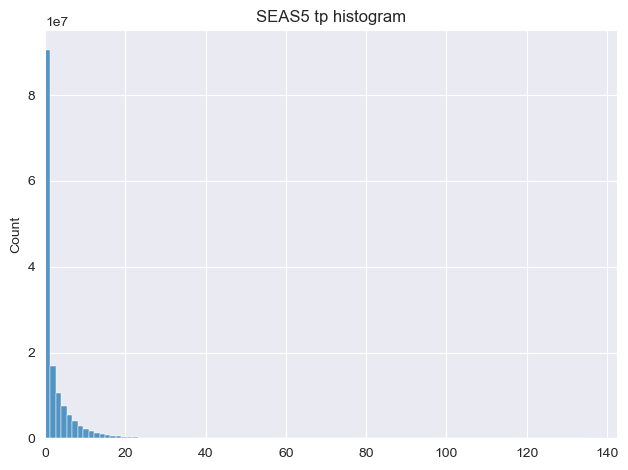

In [9]:
datasets = []
files = list(Path(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated").glob("*disaggregated.nc"))
for file in files: # prepare data for climpred
    ds = xr.open_dataset(file, chunks="auto")
    ds = ds.rename({"number": "member"})
    ds = ds.assign_coords({"init": (ds.time.values[0] - np.timedelta64(1, "D"))}).expand_dims("init")
    ds = set_integer_time_axis(ds)
    ds = ds.rename({"time": "lead"})
    ds.lead.attrs["units"] = "days"
    datasets.append(ds)
hc = xr.concat(datasets, dim="init")
hc = hc["tp"]
attrs = hc.attrs
hc *= 1_000 # conversion to mm
hc.attrs["units"] = "mm" # update unit to mm

print(f"{hc.size} data points... quite a bit of data! Shape: {hc.shape}")

# Deleting of <0 tp values as above:
print("Just like the observations the forecasts also contain negative pr values:")
print(f"Min. {hc.min().values} \n")
hc = hc.where(hc > 0) # negative values to NAN
hc = hc.fillna(0)

print("Now the data looks good")
print(f"Max. daily precipitation: {hc.max().values}")
print(f"Min. daily precipitation: {hc.min().values} \n")

#save to netCDF
final_path = Path(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated\Final")
hc.to_netcdf(final_path / "hindcast.nc")

fig, ax = plt.subplots()
sns.histplot(hc.values.flat, ax=ax, bins=100)
ax.set_xlim(left=0)
ax.set(title="SEAS5 tp histogram")
plt.tight_layout()
fig.savefig(final_path / "SEAS5_hindcast_hist.png", dpi=300)

del final_path

# Terminology
As retrieved from [here](https://climpred.readthedocs.io/en/stable/)
* **initialized ensemble** the hindcast or forecast DataSet which includes the members
* **member** a member of an ensemble (forecast)
* See more terminology guidance [here](https://climpred.readthedocs.io/en/stable/terminology.html)